# Basic bipartite graph generation demo (IEEE)

### Overview

This notebook demonstrates an example of mimicking a bipartite graph structure by providing an edge list of the target graph directly to the graph generator, responsible for generating the structure. The target graph will be the one from [IEEE](https://www.kaggle.com/c/ieee-fraud-detection) dataset. 

### Content

1. [Preprocessing (graph loading)](#1)
1. [Fitting graph generator](#2)
1. [Graph generation](#3)
1. [Result analysis](#4)

### Imports

In [1]:
import math
import numpy as np
import pandas as pd  

from syngen.generator.graph import RMATBipartiteGenerator, RandomBipartite

from syngen.analyzer.graph import Graph
from syngen.analyzer.graph.analyser import AnalysisModule
from syngen.analyzer.graph.stats import get_dd_simmilarity_score

<a id="1"></a>
### Load graph

[IEEE](https://www.kaggle.com/c/ieee-fraud-detection) dataset is stored as a csv file; however, we only require the corresponding graph structure, which could be extracted from `user_id` and `product_id` columns.

**Note**: to obtain the datasets run the `/scripts/get_datasets.sh` script as described in the `README.md`

In [2]:
# extract graph structure data
df = pd.read_csv('/workspace/data/ieee-fraud/data.csv')
df = df[['user_id', 'product_id']]  

# encode nodes
src_ids =  df['user_id'].astype("category").cat.codes.astype(int).values 
src_nodes_set = set(src_ids)
dst_ids = df['product_id'].astype("category").cat.codes.astype(int).values + len(src_nodes_set)
dst_nodes_set = set(dst_ids)

# make undirected graph
src_dst = list(zip(src_ids, dst_ids))    
dst_src = list(zip(dst_ids, src_ids))
graph_orig = list(set(src_dst + dst_src)) 

# extract graph info
num_edges = len(graph_orig) // 2
num_nodes = np.max(graph_orig) - np.min(graph_orig) + 1
num_edges, num_nodes

(52008, 17289)

<a id="2"></a>
### Fit generator to graph

Now that we have loaded the original dataset, and extracted the graph structure, a `RMATBipartiteGenerator` is instantiated to fit on this graph.

In [3]:
static_graph_generator = RMATBipartiteGenerator()
static_graph_generator.fit(graph_orig, src_nodes_set, dst_nodes_set, is_directed=False)

/workspace/syngen/generator/graph/fitter.py:111: UserWarning: the optimization function is constant for the FastFitter. Please, use Fitter class instead.
  warnings.warn("the optimization function is constant for the FastFitter. Please, use Fitter class instead.")


In [4]:
print("FIT RESULTS", static_graph_generator.get_fit_results())

FIT RESULTS ((0.43224427700042733, 0.22040712833404563, 0.06775572299957267, 0.27959287166595437), None)


<a id="3"></a>
### Generate graphs

The fitted generator can be used to generate graphs of arbitrary size.
A few examples are provided below

In [5]:
graph_proper = static_graph_generator.generate(len(src_nodes_set),
                                                  len(dst_nodes_set),
                                                  num_edges,
                                                  num_edges, 
                                                  is_directed=False, 
                                                  noise=0.5)

In [6]:
graph_proper_10x = static_graph_generator.generate(len(src_nodes_set)*math.sqrt(10),
                                                      len(dst_nodes_set)*math.sqrt(10),
                                                      num_edges*10,
                                                      num_edges*10,
                                                      is_directed=False, 
                                                      noise=0.5)

In [7]:
random_graph_generator = RandomBipartite(seed=42)
graph_random = random_graph_generator.generate(len(src_nodes_set),
                                                  len(dst_nodes_set),
                                                  num_edges,
                                                  num_edges, 
                                                  is_directed=False, 
                                                  noise=0.0)

In [8]:
graph_random_10x = random_graph_generator.generate(len(src_nodes_set)*math.sqrt(10),
                                                      len(dst_nodes_set)*math.sqrt(10),
                                                      num_edges*10,
                                                      num_edges*10,
                                                      is_directed=False, 
                                                      noise=0.0)

### Convert graph to SNAP

Next the original graph is converted to [SNAP](https://snap.stanford.edu/), where the graph analyzer is used to analyze the generated graphs with the original.

In [9]:
np.savetxt('/workspace/data/ieee_demo_orig.txt', graph_orig, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/ieee_demo_proper.txt', graph_proper, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/ieee_demo_random.txt', graph_random, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/ieee_demo_proper_10.txt', graph_proper_10x, fmt='%i', delimiter='\t')
np.savetxt('/workspace/data/ieee_demo_random_10.txt', graph_random_10x, fmt='%i', delimiter='\t')

In [10]:
proper_graph = Graph('/workspace/data/ieee_demo_proper.txt', name='properly_generated', load_eagerly=True, is_directed=False)
random_graph = Graph('/workspace/data/ieee_demo_random.txt', name='randomly_generated', load_eagerly=True, is_directed=False)
proper_graph_10x = Graph('/workspace/data/ieee_demo_proper_10.txt', name='properly_generated_10', load_eagerly=True, is_directed=False)
random_graph_10x = Graph('/workspace/data/ieee_demo_random_10.txt', name='randomly_generated_10', load_eagerly=True, is_directed=False)

orig_graph = Graph('/workspace/data/ieee_demo_orig.txt', name='original', load_eagerly=True, is_directed=False)
all_graphs = [proper_graph, random_graph, orig_graph, proper_graph_10x, random_graph_10x]

<a id="4"></a>
### Result analysis

In [11]:
orig_proper = get_dd_simmilarity_score(graph_orig, graph_proper, cdf_points=1000)
orig_random = get_dd_simmilarity_score(graph_orig, graph_random, cdf_points=1000)

print("DEGREE SIMILLARITY SCORE")
print("ORIG vs PROPER:", orig_proper)
print("ORIG vs RANDOM:", orig_random)

DEGREE SIMILLARITY SCORE
ORIG vs PROPER: 0.9609898378110571
ORIG vs RANDOM: 0.9580625100476736


In [12]:
graph_analyser = AnalysisModule()
df = graph_analyser.compare_graph_stats(*all_graphs)
df

,Category,Statistic,properly_generated,randomly_generated,original,properly_generated_10,randomly_generated_10
0,Global stats,Nodes,14265,23606,17289,46862,55880
1,Global stats,Edges,52008,52008,52008,520080,520080
2,Global stats,Density,0.0005,0.0002,0.0003,0.0005,0.0003
3,Global stats,Average degree,3.65,2.2,3.01,11.1,9.31
4,Global stats,Zero deg nodes,0,0,0,0,0
5,Global stats,Zero in deg nodes,0,0,0,0,0
6,Global stats,Zero out deg nodes,0,0,0,0,0
7,Global stats,Self loops,0,0,0,0,0
8,Global stats,Bidirectional edges,52008,52008,52008,520080,520080
9,Global stats,Unique undirected edges,52008,52008,52008,520080,520080


The degree distribution comparison and hop plots can also be visualized by calling the `compare_graph_plots` fn on the analyzer.

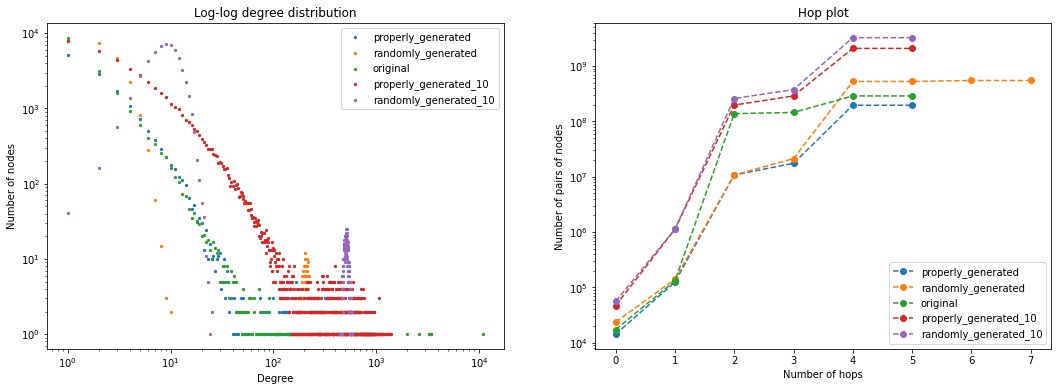

In [13]:
_ = graph_analyser.compare_graph_plots(*all_graphs)